# HR-Pulse — EDA + Cleaning + Entraînement Modèle ML
### Dataset → Exploration → Nettoyage → Outliers → Régression Salariale

In [35]:
# === Imports ===
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
warnings.filterwarnings('ignore')

# === Machine Learning ===
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
)



# 1. Configuration

In [36]:
from pathlib import Path


MODEL_PATH = '../../models/salary_model.pkl'
DATA_PATH  = '../../data/raw/jobs.csv'

      
print('✅ Configuration chargée')
# print(f'   Project root : {PROJECT_ROOT}')
print(f'   Dataset      : {DATA_PATH}')
print(f'   Modèle       : {MODEL_PATH}')
# print(f'   CSV existe   : {DATA_PATH.exists()}')


✅ Configuration chargée
   Dataset      : ../../data/raw/jobs.csv
   Modèle       : ../../models/salary_model.pkl


# 2. Chargement du Dataset

In [37]:
df = pd.read_csv(DATA_PATH)
print(f'Shape brut : {df.shape}')
df.head(3)


Shape brut : (672, 15)


,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna"
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),-1
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),-1


In [38]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    str    
 2   Salary Estimate    672 non-null    str    
 3   Job Description    672 non-null    str    
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    str    
 6   Location           672 non-null    str    
 7   Headquarters       672 non-null    str    
 8   Size               672 non-null    str    
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    str    
 11  Industry           672 non-null    str    
 12  Sector             672 non-null    str    
 13  Revenue            672 non-null    str    
 14  Competitors        672 non-null    str    
dtypes: float64(1), int64(2), str(12)
memory usage: 2.4 MB


In [39]:
print('=== Problèmes détectés AVANT nettoyage ===')
for col in df.columns:
    count = (df[col].astype(str) == '-1').sum()
    if count > 0:
        print(f'  {col:<25} : {count} valeurs -1')
print(f'\n  Rating == -1           : {(df["Rating"] == -1).sum()} lignes')
print(f'  Founded == -1          : {(df["Founded"] == -1).sum()} lignes')
print(f'  Company avec \\n       : {df["Company Name"].str.contains(chr(10)).sum()} lignes')

=== Problèmes détectés AVANT nettoyage ===
  Headquarters              : 31 valeurs -1
  Size                      : 27 valeurs -1
  Founded                   : 118 valeurs -1
  Type of ownership         : 27 valeurs -1
  Industry                  : 71 valeurs -1
  Sector                    : 71 valeurs -1
  Revenue                   : 27 valeurs -1
  Competitors               : 501 valeurs -1

  Rating == -1           : 50 lignes
  Founded == -1          : 118 lignes
  Company avec \n       : 622 lignes


# 3. Nettoyage du Dataset

In [40]:
def clean_salary(salary_str: str) -> float | None:
    """
    '$137K-$171K (Glassdoor est.)' -> 154000.0
    Retourne None si non parsable.
    """
    if not isinstance(salary_str, str):
        return None
    numbers = re.findall(r'\d+', salary_str.replace(',', ''))
    if len(numbers) < 2:
        return None
    low  = float(numbers[0]) * 1000
    high = float(numbers[1]) * 1000
    return (low + high) / 2


def clean_text_col(value: str) -> str:
    """'Healthfirst\\n3.1' -> 'Healthfirst'."""
    if not isinstance(value, str):
        return ''
    return re.sub(r'\n.*', '', value).strip()


def clean_minus_one(value):
    """Remplace -1 et '-1' par NaN."""
    if str(value).strip() == '-1' or value == -1:
        return np.nan
    return value


print('✅ Fonctions de nettoyage définies')

✅ Fonctions de nettoyage définies


In [41]:
df_clean = df.copy()

# Colonnes texte avec \n collé
df_clean['job_title_clean']   = df_clean['Job Title'].apply(clean_text_col)
df_clean['company_clean']     = df_clean['Company Name'].apply(clean_text_col)

# Salaire -> float
df_clean['salary_avg']        = df_clean['Salary Estimate'].apply(clean_salary)

# Description
df_clean['description_clean'] = df_clean['Job Description'].fillna('')

# Rating et Founded : -1 -> NaN
df_clean['Rating']  = df_clean['Rating'].replace(-1, np.nan)
df_clean['Founded'] = df_clean['Founded'].replace(-1, np.nan)

# Colonnes catégorielles avec '-1' -> NaN
for col in ['Sector', 'Industry', 'Headquarters', 'Competitors',
            'Type of ownership', 'Size', 'Revenue']:
    df_clean[col] = df_clean[col].apply(clean_minus_one)

# Supprimer lignes sans titre
df_clean = df_clean[df_clean['job_title_clean'] != ''].reset_index(drop=True)

print(f'✅ Nettoyage terminé — Shape : {df_clean.shape}')

✅ Nettoyage terminé — Shape : (672, 19)


In [42]:
print('=== NaN après nettoyage ===')
print(df_clean[['job_title_clean','company_clean','salary_avg','Rating','Sector','Founded']].isnull().sum())
print()
df_clean[['job_title_clean','company_clean','salary_avg','Rating']].head(5)

=== NaN après nettoyage ===
job_title_clean      0
company_clean        0
salary_avg           0
Rating              50
Sector              71
Founded            118
dtype: int64



,job_title_clean,company_clean,salary_avg,Rating
0,Sr Data Scientist,Healthfirst,154000.0,3.1
1,Data Scientist,ManTech,154000.0,4.2
2,Data Scientist,Analysis Group,154000.0,3.8
3,Data Scientist,INFICON,154000.0,3.5
4,Data Scientist,Affinity Solutions,154000.0,2.9


# 4. EDA — Exploration des Données

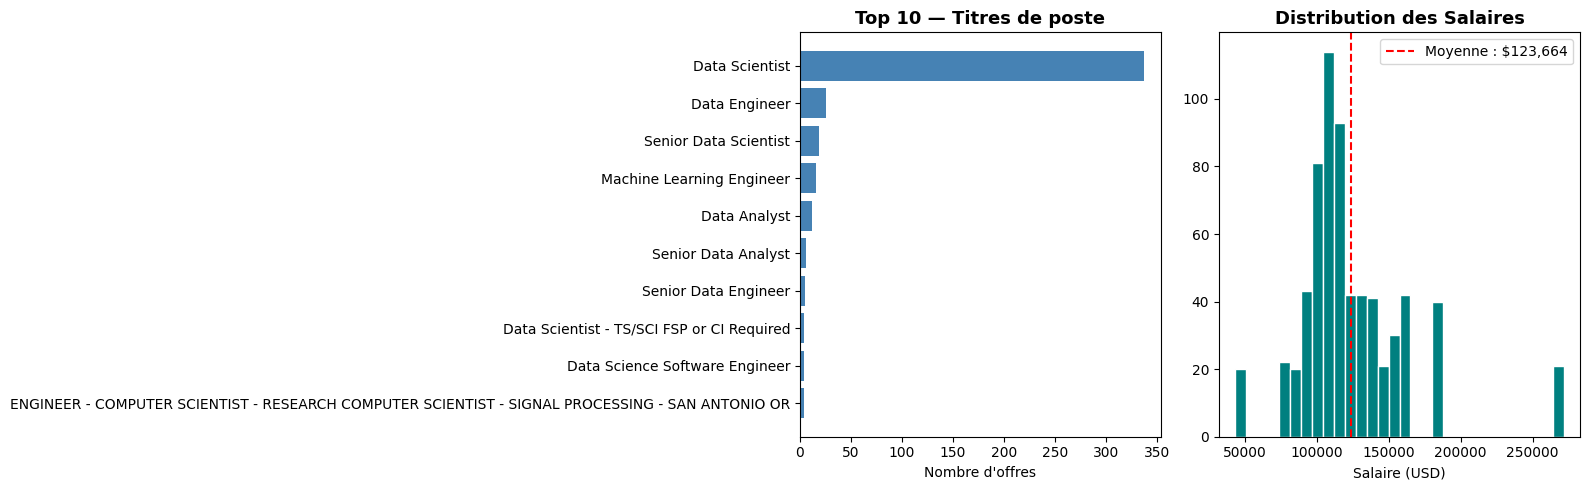

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

top_titles = df_clean['job_title_clean'].value_counts().head(10)
axes[0].barh(top_titles.index[::-1], top_titles.values[::-1], color='steelblue')
axes[0].set_title('Top 10 — Titres de poste', fontsize=13, fontweight='bold')
axes[0].set_xlabel("Nombre d'offres")

axes[1].hist(df_clean['salary_avg'].dropna(), bins=30, color='teal', edgecolor='white')
axes[1].axvline(df_clean['salary_avg'].mean(), color='red', linestyle='--',
                label=f"Moyenne : ${df_clean['salary_avg'].mean():,.0f}")
axes[1].set_title('Distribution des Salaires', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Salaire (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()

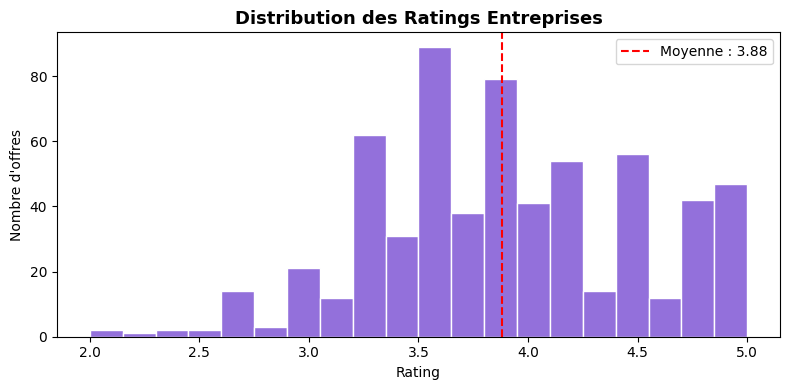

In [44]:
df_rating = df_clean[df_clean['Rating'].notna()]

plt.figure(figsize=(8, 4))
plt.hist(df_rating['Rating'], bins=20, color='mediumpurple', edgecolor='white')
plt.axvline(df_rating['Rating'].mean(), color='red', linestyle='--',
            label=f"Moyenne : {df_rating['Rating'].mean():.2f}")
plt.title('Distribution des Ratings Entreprises', fontsize=13, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel("Nombre d'offres")
plt.legend()
plt.tight_layout()
plt.show()

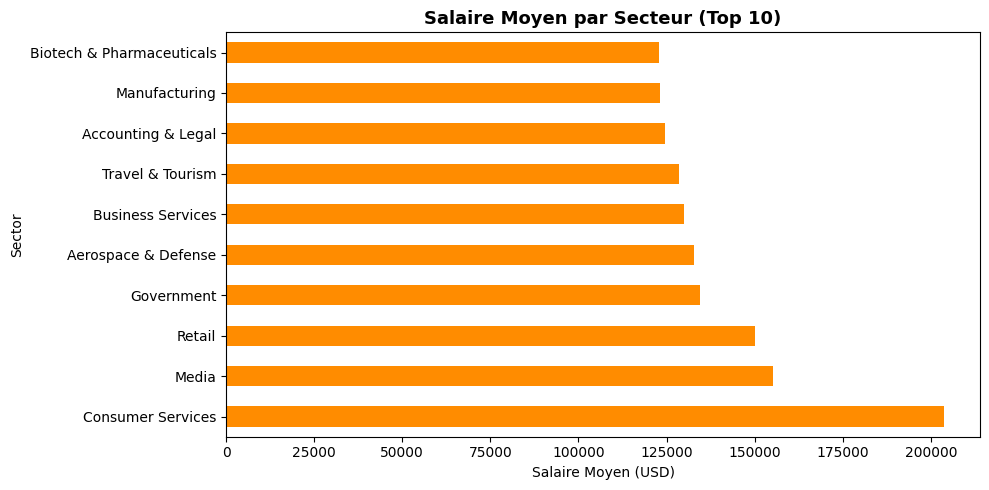

In [45]:
salary_by_sector = (
    df_clean.groupby('Sector')['salary_avg']
    .mean().dropna()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
salary_by_sector.plot(kind='barh', color='darkorange')
plt.title('Salaire Moyen par Secteur (Top 10)', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

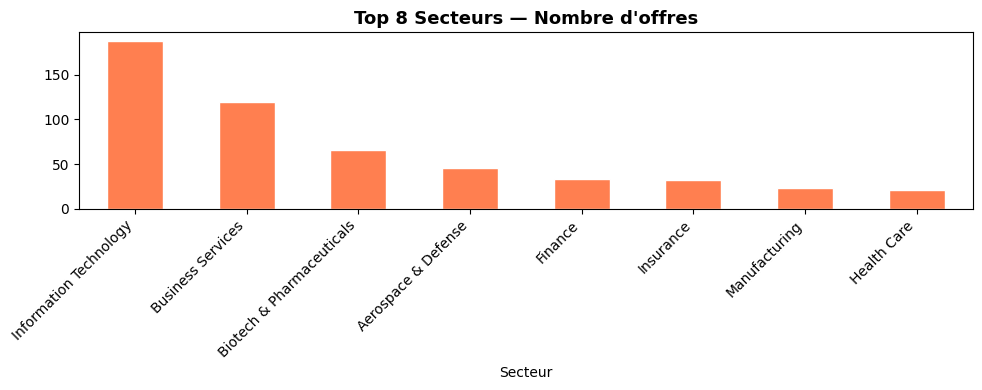

In [46]:
top_sectors = df_clean['Sector'].value_counts().head(8)

plt.figure(figsize=(10, 4))
top_sectors.plot(kind='bar', color='coral', edgecolor='white')
plt.title("Top 8 Secteurs — Nombre d'offres", fontsize=13, fontweight='bold')
plt.xlabel('Secteur')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

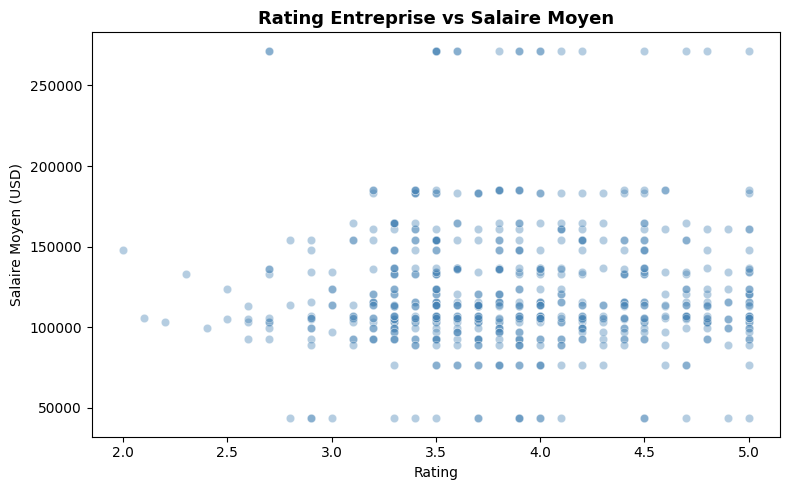

Corrélation Rating <-> Salaire : 0.001


In [47]:
df_corr = df_clean[['salary_avg', 'Rating']].dropna()

plt.figure(figsize=(8, 5))
plt.scatter(df_corr['Rating'], df_corr['salary_avg'],
            alpha=0.4, color='steelblue', edgecolors='white', linewidth=0.5)
plt.title('Rating Entreprise vs Salaire Moyen', fontsize=13, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

corr = df_corr['salary_avg'].corr(df_corr['Rating'])
print(f'Corrélation Rating <-> Salaire : {corr:.3f}')

# 5. Gestion des Outliers (Salaire)

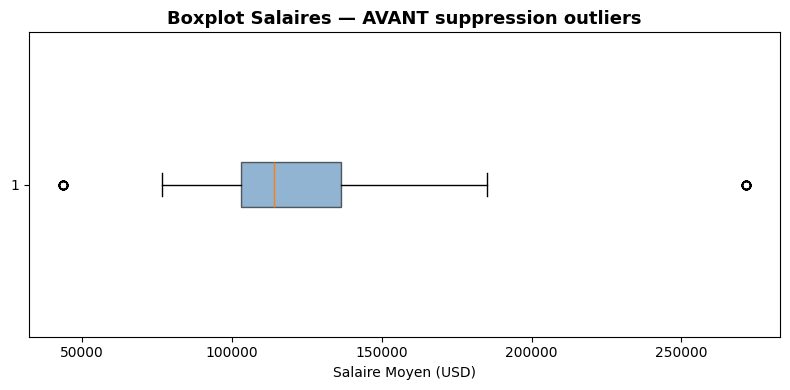

count       672.000000
mean     123663.690476
std       39580.267895
min       43500.000000
25%      103000.000000
50%      114000.000000
75%      136500.000000
max      271500.000000
Name: salary_avg, dtype: float64


In [48]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_clean['salary_avg'].dropna(), vert=False, patch_artist=True,
            boxprops=dict(facecolor='steelblue', alpha=0.6))
plt.title('Boxplot Salaires — AVANT suppression outliers', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

print(df_clean['salary_avg'].describe())

In [49]:
#? Méthode IQR : tout ce qui dépasse Q1 - 1.5*IQR ou Q3 + 1.5*IQR est un outlier

Q1  = df_clean['salary_avg'].quantile(0.25)
Q3  = df_clean['salary_avg'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[
    (df_clean['salary_avg'] < lower_bound) |
    (df_clean['salary_avg'] > upper_bound)
]

print(f'Q1             : ${Q1:,.0f}')
print(f'Q3             : ${Q3:,.0f}')
print(f'IQR            : ${IQR:,.0f}')
print(f'Borne basse    : ${lower_bound:,.0f}')
print(f'Borne haute    : ${upper_bound:,.0f}')
print(f'Outliers       : {len(outliers)} lignes ({len(outliers)/len(df_clean)*100:.1f}%)')
print()
outliers[['job_title_clean','Salary Estimate','salary_avg']].head(10)

Q1             : $103,000
Q3             : $136,500
IQR            : $33,500
Borne basse    : $52,750
Borne haute    : $186,750
Outliers       : 41 lignes (6.1%)



,job_title_clean,Salary Estimate,salary_avg
467,Data & Machine Learning Scientist,$31K-$56K (Glassdoor est.),43500.0
468,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
469,"VP, Data Science",$31K-$56K (Glassdoor est.),43500.0
470,Senior Business Intelligence Analyst,$31K-$56K (Glassdoor est.),43500.0
471,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
472,Data Engineer - Kafka,$31K-$56K (Glassdoor est.),43500.0
473,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
474,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
475,Data Scientist,$31K-$56K (Glassdoor est.),43500.0
476,Data Scientist,$31K-$56K (Glassdoor est.),43500.0


In [50]:
# BUG CORRIGÉ : il faut filtrer les deux bornes (low ET high)
# Ancienne version (BUG) :
#   (df_clean['salary_avg'] >= lower_bound) | (df_clean['salary_avg'].isna())
# → les valeurs > upper_bound n'étaient JAMAIS supprimées !

df_clean = df_clean[
    df_clean['salary_avg'].isna() |
    (
        (df_clean['salary_avg'] >= lower_bound) &
        (df_clean['salary_avg'] <= upper_bound)
    )
].reset_index(drop=True)

print(f'✅ Outliers supprimés (bornes basse ET haute)')
print(f'   Shape avant : {df.shape[0]} lignes')
print(f'   Shape après : {df_clean.shape[0]} lignes')
print(f'   Supprimées  : {df.shape[0] - df_clean.shape[0]} lignes')


✅ Outliers supprimés (bornes basse ET haute)
   Shape avant : 672 lignes
   Shape après : 631 lignes
   Supprimées  : 41 lignes


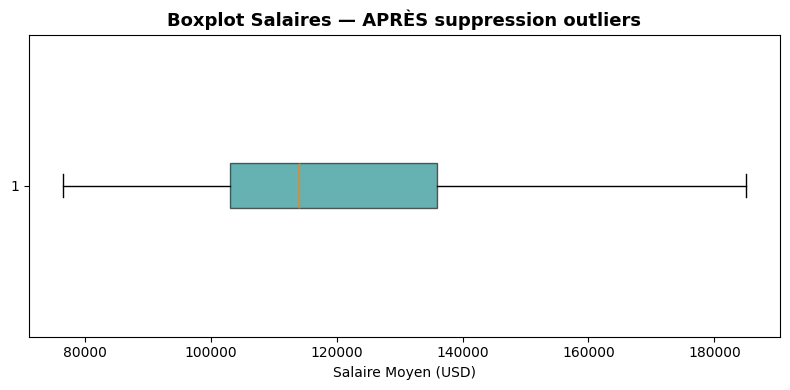

count       631.000000
mean     121284.469097
std       27025.082053
min       76500.000000
25%      103000.000000
50%      114000.000000
75%      136000.000000
max      185000.000000
Name: salary_avg, dtype: float64


In [51]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_clean['salary_avg'].dropna(), vert=False, patch_artist=True,
            boxprops=dict(facecolor='teal', alpha=0.6))
plt.title('Boxplot Salaires — APRÈS suppression outliers', fontsize=13, fontweight='bold')
plt.xlabel('Salaire Moyen (USD)')
plt.tight_layout()
plt.show()

print(df_clean['salary_avg'].describe())

# 6. Entraînement du Modèle ML

In [52]:
# ──────────────────────────────────────────────────────────────────
# DIAGNOSTIC : ce dataset n'a que 26 valeurs uniques de salaire.
# Les estimations Glassdoor sont regroupées en buckets prédéfinis.
# → La régression est inadaptée. On passe à la CLASSIFICATION.
# On prédit la fourchette salariale (bracket) plutôt que le montant.
# ──────────────────────────────────────────────────────────────────
print(f"Valeurs uniques salary_avg : {df_clean['salary_avg'].nunique()} (sur {len(df_clean)} lignes)")
print('→ Classification par bracket salariale plus adaptée que la régression\n')

# Définir 4 brackets équilibrés
bins   = [0, 95_000, 115_000, 140_000, float('inf')]
labels = ['< $95K', '$95K–$115K', '$115K–$140K', '> $140K']

df_model = df_clean.copy()
df_model = df_model.dropna(subset=['salary_avg']).reset_index(drop=True)
df_model['salary_bracket'] = pd.cut(df_model['salary_avg'], bins=bins, labels=labels)

# Features retenues
FEATURES = ['job_title_clean', 'Sector', 'Size', 'Type of ownership']
TARGET   = 'salary_bracket'

for col in FEATURES:
    df_model[col] = df_model[col].fillna('Unknown')

print('Distribution des brackets :')
print(df_model[TARGET].value_counts().sort_index())
print(f'\nDataset modèle : {df_model.shape[0]} offres avec salaire')


Valeurs uniques salary_avg : 24 (sur 631 lignes)
→ Classification par bracket salariale plus adaptée que la régression

Distribution des brackets :
salary_bracket
< $95K          85
$95K–$115K     256
$115K–$140K    157
> $140K        133
Name: count, dtype: int64

Dataset modèle : 631 offres avec salaire


In [53]:
X = df_model[FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train : {len(X_train)} offres | Test : {len(X_test)} offres')


Train : 504 offres | Test : 127 offres


In [54]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), FEATURES),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        class_weight='balanced',  # compense les classes déséquilibrées
    )),
])

pipeline.fit(X_train, y_train)
print('✅ Modèle RandomForestClassifier entraîné')


✅ Modèle RandomForestClassifier entraîné


In [55]:
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('=== Résultats du modèle ===')
print(f'Accuracy : {acc:.3f}  (baseline aléatoire = 0.25)')
print()
print(classification_report(y_test, y_pred))


=== Résultats du modèle ===
Accuracy : 0.346  (baseline aléatoire = 0.25)

              precision    recall  f1-score   support

 $115K–$140K       0.38      0.25      0.30        32
  $95K–$115K       0.48      0.49      0.49        51
      < $95K       0.13      0.18      0.15        17
     > $140K       0.26      0.30      0.28        27

    accuracy                           0.35       127
   macro avg       0.31      0.30      0.30       127
weighted avg       0.36      0.35      0.35       127



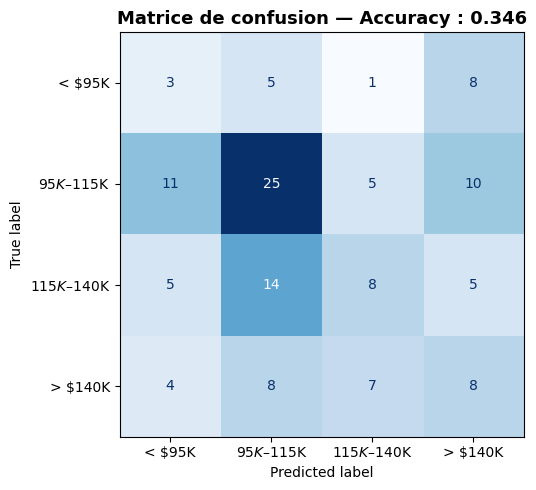

In [56]:
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=labels),
    display_labels=labels
).plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title(f'Matrice de confusion — Accuracy : {acc:.3f}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


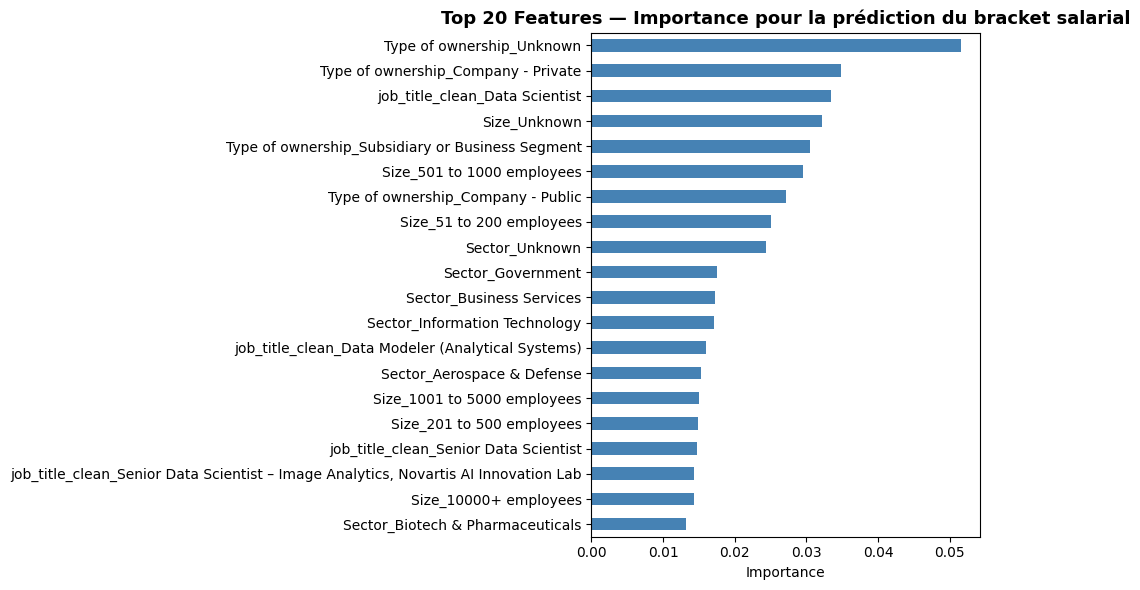

In [57]:
# Feature importance — RandomForest
feature_names = pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(FEATURES)
importances = pipeline.named_steps['clf'].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
fi[::-1].plot(kind='barh', color='steelblue')
plt.title('Top 20 Features — Importance pour la prédiction du bracket salarial',
          fontsize=13, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [58]:
test_cases = [
    {'job_title_clean': 'Data Scientist',            'Sector': 'Information Technology', 'Size': '1001 to 5000 employees', 'Type of ownership': 'Company - Public'},
    {'job_title_clean': 'Data Engineer',             'Sector': 'Information Technology', 'Size': '201 to 500 employees',   'Type of ownership': 'Company - Private'},
    {'job_title_clean': 'Machine Learning Engineer', 'Sector': 'Finance',                'Size': '10000+ employees',        'Type of ownership': 'Company - Public'},
    {'job_title_clean': 'Data Analyst',              'Sector': 'Business Services',      'Size': '51 to 200 employees',     'Type of ownership': 'Company - Private'},
]

print('=== Exemples de prédictions de bracket salarial ===')
for tc in test_cases:
    row   = pd.DataFrame([tc])
    pred  = pipeline.predict(row)[0]
    proba = pipeline.predict_proba(row)[0]
    conf  = max(proba) * 100
    print(f"  {tc['job_title_clean']:<32} → {pred}  (confiance : {conf:.0f}%)")


=== Exemples de prédictions de bracket salarial ===
  Data Scientist                   → < $95K  (confiance : 26%)
  Data Engineer                    → $95K–$115K  (confiance : 30%)
  Machine Learning Engineer        → $115K–$140K  (confiance : 27%)
  Data Analyst                     → $95K–$115K  (confiance : 29%)


MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(pipeline, MODEL_PATH)
print(f'✅ Modèle sauvegardé -> {MODEL_PATH.resolve()}')

# Sauvegarder aussi les métadonnées utiles pour predictor.py
import json as _json
meta = {'features': FEATURES, 'labels': list(labels), 'model_type': 'classifier'}
meta_path = MODEL_PATH.with_suffix('.json')
meta_path.write_text(_json.dumps(meta, indent=2))
print(f'✅ Métadonnées sauvegardées -> {meta_path}')


In [61]:
# loaded_model = joblib.load(MODEL_PATH)
# sample = pd.DataFrame([{
#     'job_title_clean': 'Data Scientist',
#     'Sector':          'Information Technology',
#     'Size':            '1001 to 5000 employees',
#     'Type of ownership': 'Company - Public',
# }])
# pred = loaded_model.predict(sample)[0]
# print(f'✅ Modèle rechargé avec succès')
# print(f'   Bracket prédit : {pred}')


In [60]:
# # Vérification : rechargement et test rapide
# loaded_model = joblib.load(model_path)
# test_pred    = loaded_model.predict(pd.Series(['Data Scientist Python machine learning']))[0]

# print(f'✅ Modèle rechargé avec succès')
# print(f'   Test prédiction : ${test_pred:,.0f} / an')
